### Imports, config and paths

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

repo_root = Path.cwd().parents[0]
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

from helper.utils import find_repo_root, load_pipeline_config, ensure_dir, save_run_log
from helper.sustainability_metrics import (
    sustainability_v1,
    sustainability_pca_energy_index,
    sustainability_from_assumptions
)

repo_root = find_repo_root()
cfg = load_pipeline_config(repo_root)

processed_dir = repo_root / cfg["paths"]["processed_dir"]
results_dir   = repo_root / cfg["paths"]["results_dir"]
models_dir    = repo_root / cfg["paths"]["models_dir"]

ensure_dir(results_dir)

print("processed_dir:", processed_dir)
print("results_dir:", results_dir)
print("models_dir:", models_dir)


processed_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/processed
results_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/data/results
models_dir: /home/097e80f6-6687-4e65-aab6-9abf7b887006/GreenInformationFactory_Prototype/notebooks/models


### Load best model bundle

In [2]:
import pickle

bundle_path = models_dir / "all_models.pkl"
assert bundle_path.exists(), f"Missing model bundle: {bundle_path}"

with open(bundle_path, "rb") as f:
    bundle = pickle.load(f)

best_name  = bundle["best_model_name"]
best_model = bundle["best_model"]

print("✅ Best model:", best_name)


✅ Best model: rf


### Load baseline dataset - validation preferred

We use Validation as "unseen holdout" to build realistic scenarios.

In [3]:
def load_split(split_name: str):
    split_dir = processed_dir / split_name
    assert split_dir.exists(), f"Split folder not found: {split_dir}"

    x_candidates = ["X_val.csv","X_validation.csv","X_test.csv","X_train.csv",
                    "BioFairNet_Pilot1_Testrun_Test_in.csv","BioFairNet_Pilot1_Testrun_Train_in.csv"]
    y_candidates = ["y_val.csv","y_validation.csv","y_test.csv","y_train.csv",
                    "BioFairNet_Pilot1_Testrun_Test_out.csv","BioFairNet_Pilot1_Testrun_Train_out.csv"]

    x_path = next((split_dir / f for f in x_candidates if (split_dir / f).exists()), None)
    y_path = next((split_dir / f for f in y_candidates if (split_dir / f).exists()), None)

    if x_path is None or y_path is None:
        raise FileNotFoundError(f"Could not find X/y in {split_dir}. Found: {[p.name for p in split_dir.glob('*.csv')]}")

    X = pd.read_csv(x_path)
    y = pd.read_csv(y_path).squeeze("columns")
    return X, y, x_path.name, y_path.name

val_folder = "Validation" if (processed_dir / "Validation").exists() else "Val"
X_base, y_base, xvn, yvn = load_split(val_folder)
print("✅ Baseline split:", val_folder, xvn, yvn, X_base.shape)

X_base.head()


✅ Baseline split: Validation X_val.csv y_val.csv (1845, 3)


,time_s,Temperature (°C),Stiring
0,1183.0,193.3,0.1
1,1038.0,182.0,0.1
2,9217.0,250.0,0.1
3,908.0,171.9,0.1
4,8492.0,250.2,0.1


### Choose scenario variables

auto-dectect + manual override. This cell tries to find likely columns. Possible to override by setting `scenario_var = [...]`.

In [4]:
def pick_first(cols, candidates):
    for c in candidates:
        if c in cols:
            return c
    return None

cols = list(X_base.columns)

time_col = pick_first(cols, ["time_s","time","t","Time"])
temp_col = pick_first(cols, ["temperature","temp","T","Temperature"])
stir_col = pick_first(cols, ["stirring","Stirring","stiring","Stiring","rpm","RPM"])

auto = [c for c in [time_col, temp_col, stir_col] if c is not None]
print("Auto-detected scenario vars:", auto)

# ---- Override here if needed ----
scenario_vars = auto  # e.g., ["time_s","temperature","Stiring"]
assert len(scenario_vars) >= 1, "No scenario variables found. Choose one column from X_base.columns."
scenario_vars


Auto-detected scenario vars: ['time_s', 'Stiring']


['time_s', 'Stiring']

### Build Scenario grid around realistic ranges

Build a grid from quantiles (10% ... 90%) of each variable for stability.

In [5]:
def scenario_range(series, q_low=0.10, q_high=0.90):
    s = pd.to_numeric(series, errors="coerce")
    lo = float(s.quantile(q_low))
    hi = float(s.quantile(q_high))
    if not np.isfinite(lo) or not np.isfinite(hi) or abs(hi-lo) < 1e-12:
        lo, hi = float(s.min()), float(s.max())
    if not np.isfinite(lo) or not np.isfinite(hi) or abs(hi-lo) < 1e-12:
        lo, hi = 0.0, 1.0
    return lo, hi

grid_points = 25  # adjust (e.g., 15/25/41)
grid_1d = {}
for v in scenario_vars:
    lo, hi = scenario_range(X_base[v])
    grid_1d[v] = np.linspace(lo, hi, grid_points)
    print(f"{v}: [{lo:.4g}, {hi:.4g}] with {grid_points} points")

grid_1d


time_s: [869.6, 8279] with 25 points
Stiring: [0, 1] with 25 points


{'time_s': array([ 869.6       , 1178.31666667, 1487.03333333, 1795.75      ,
        2104.46666667, 2413.18333333, 2721.9       , 3030.61666667,
        3339.33333333, 3648.05      , 3956.76666667, 4265.48333333,
        4574.2       , 4882.91666667, 5191.63333333, 5500.35      ,
        5809.06666667, 6117.78333333, 6426.5       , 6735.21666667,
        7043.93333333, 7352.65      , 7661.36666667, 7970.08333333,
        8278.8       ]),
 'Stiring': array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
        0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
        0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
        0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
        0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])}

### Create scenarios

One-way sensitivity around a baseline row. This approach is beginner friendly and fast. To adapted by more dedictated approaches later.

In [6]:
baseline_idx = 0  # choose any row
baseline = X_base.iloc[[baseline_idx]].copy()

def one_way_scenarios(baseline_row: pd.DataFrame, grid_1d: dict):
    rows = []
    for var, values in grid_1d.items():
        for val in values:
            r = baseline_row.copy()
            r[var] = val
            r["_var"] = var
            r["_val"] = float(val)
            rows.append(r)
    return pd.concat(rows, ignore_index=True)

scenarios = one_way_scenarios(baseline, grid_1d)
print("✅ Scenarios:", scenarios.shape)
scenarios.head()


✅ Scenarios: (50, 5)


,time_s,Temperature (°C),Stiring,_var,_val
0,869.600000,193.3,0.1,time_s,869.600000
1,1178.316667,193.3,0.1,time_s,1178.316667
2,1487.033333,193.3,0.1,time_s,1487.033333
3,1795.750000,193.3,0.1,time_s,1795.750000
4,2104.466667,193.3,0.1,time_s,2104.466667


### Predict and compute sustainability proxies

In [7]:
# Predict
y_pred = best_model.predict(scenarios[cols])  # ensure same feature order as training
sc = scenarios.copy()
sc["y_pred"] = y_pred

# v1 proxy
sc_v1, drivers_v1 = sustainability_v1(sc, y_pred_col="y_pred")

# PCA proxy (adaptive fallback if only 1 driver)
sc_pca, info_pca = sustainability_pca_energy_index(sc, y_pred_col="y_pred")

# Assumptions proxy
assumptions_path = repo_root / "metadata" / "sustainability_assumptions_v1.json"
sc_assumed, info_assumed = sustainability_from_assumptions(sc, assumptions_path, y_pred_col="y_pred")

print("Drivers v1:", drivers_v1)
print("PCA mode:", info_pca.get("mode"), "cols:", info_pca.get("used_columns"))
print("Assumptions resolved:", info_assumed["resolved_driver_columns"])


Drivers v1: {'temperature': None, 'time': 'time_s', 'stirring': 'Stiring'}
PCA mode: single_column_fallback cols: ['time_s']
Assumptions resolved: {'time': 'time_s', 'temperature': None, 'stirring': 'Stiring'}


Merge into one table for the plotting:

In [8]:
out = sc[["_var","_val","y_pred"]].copy()

out["co2_v1"] = sc_v1["co2_proxy"].to_numpy()
out["mci_v1"] = sc_v1["mci_proxy"].to_numpy()

out["co2_pca"] = sc_pca["co2_pca_proxy"].to_numpy()
out["mci_pca"] = sc_pca["mci_pca_proxy"].to_numpy()

out["co2_assumed"] = sc_assumed["co2_assumed"].to_numpy()
out["mci_assumed"] = sc_assumed["mci_assumed"].to_numpy()

out.head()


,_var,_val,y_pred,co2_v1,mci_v1,co2_pca,mci_pca,co2_assumed,mci_assumed
0,time_s,869.600000,10.2932,0.014000,0.988000,0.000000,1.000000,0.000000,1.000000
1,time_s,1178.316667,13.8900,0.104244,0.873230,0.107744,0.870230,0.107744,0.870230
2,time_s,1487.033333,20.5178,0.260705,0.670172,0.281705,0.652172,0.281705,0.652172
3,time_s,1795.750000,24.0254,0.349000,0.558000,0.387500,0.525000,0.387500,0.525000
4,time_s,2104.466667,24.0204,0.360557,0.548146,0.416557,0.500146,0.416557,0.500146


### Sensitivity plots per variable

Output sensitivity:

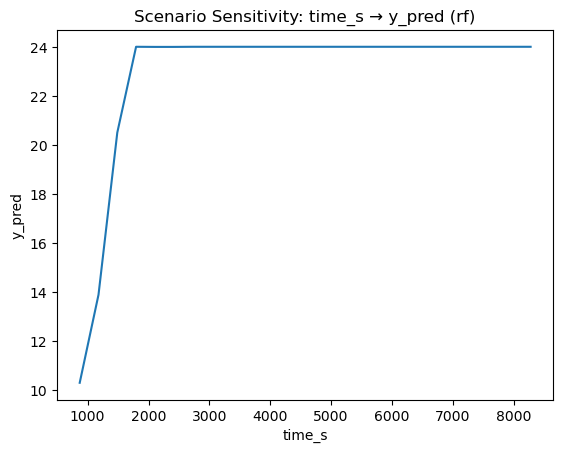

✅ Saved: data/results/scenario_y_pred_time_s_rf.png


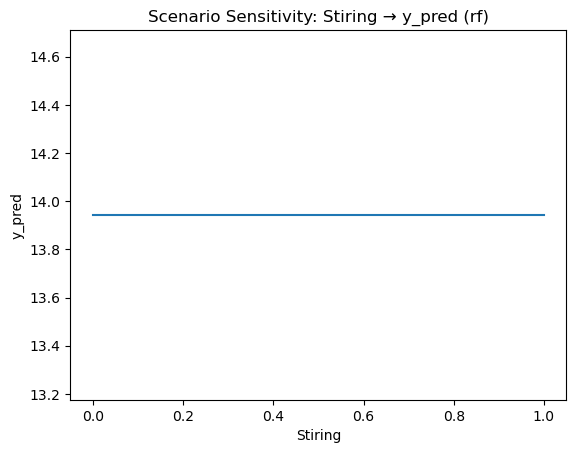

✅ Saved: data/results/scenario_y_pred_Stiring_rf.png


In [9]:
import matplotlib.pyplot as plt

for var in scenario_vars:
    dfv = out[out["_var"] == var].sort_values("_val")
    plt.figure()
    plt.title(f"Scenario Sensitivity: {var} → y_pred ({best_name})")
    plt.xlabel(var)
    plt.ylabel("y_pred")
    plt.plot(dfv["_val"], dfv["y_pred"])
    p = results_dir / f"scenario_y_pred_{var}_{best_name}.png"
    plt.savefig(p, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", p.relative_to(repo_root))


Sustainability sensitivity (CO₂ and MCI) — compare methods:

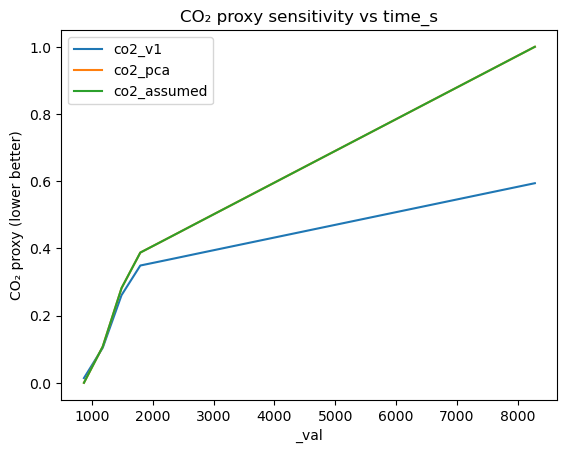

✅ Saved: data/results/scenario_co2_time_s_rf.png


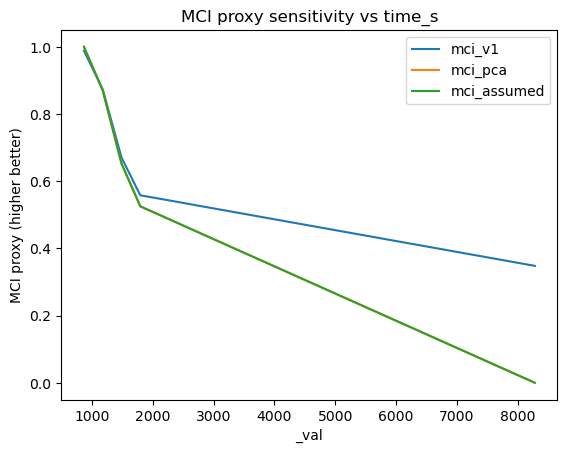

✅ Saved: data/results/scenario_mci_time_s_rf.png


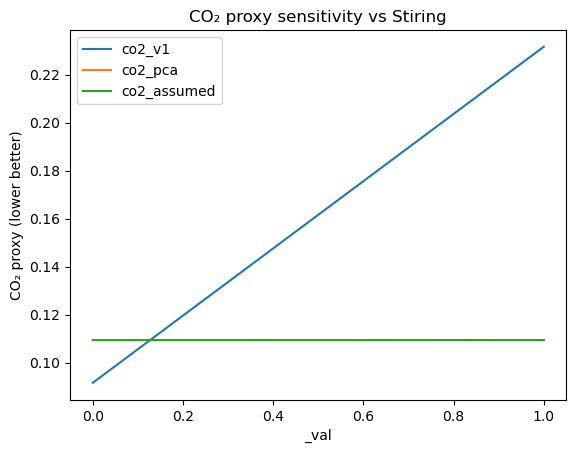

✅ Saved: data/results/scenario_co2_Stiring_rf.png


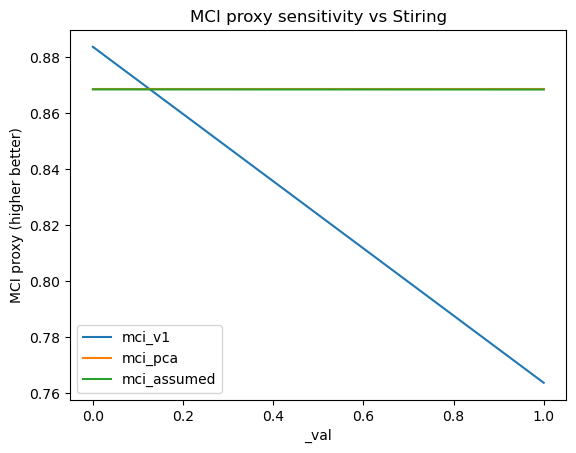

✅ Saved: data/results/scenario_mci_Stiring_rf.png


In [10]:
def plot_methods(dfv, xcol, ycols, title, ylabel, out_path):
    plt.figure()
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ylabel)
    for yc in ycols:
        plt.plot(dfv[xcol], dfv[yc], label=yc)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", out_path.relative_to(repo_root))

for var in scenario_vars:
    dfv = out[out["_var"] == var].sort_values("_val")

    plot_methods(
        dfv, "_val",
        ["co2_v1","co2_pca","co2_assumed"],
        f"CO₂ proxy sensitivity vs {var}",
        "CO₂ proxy (lower better)",
        results_dir / f"scenario_co2_{var}_{best_name}.png"
    )

    plot_methods(
        dfv, "_val",
        ["mci_v1","mci_pca","mci_assumed"],
        f"MCI proxy sensitivity vs {var}",
        "MCI proxy (higher better)",
        results_dir / f"scenario_mci_{var}_{best_name}.png"
    )


### Sustainable Region heuristic Pareto-style filter

Define a simple rule:

- CO₂ low (≤ 25th percentile)
- MCI high (≥ 75th percentile)

This can be computed per method.

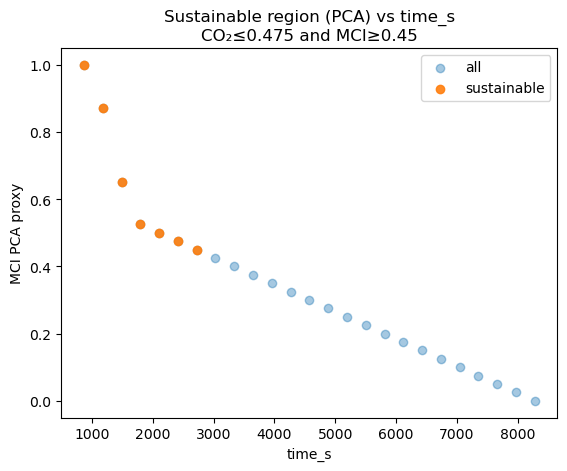

✅ Saved: data/results/scenario_sustainable_region_pca_time_s_rf.png


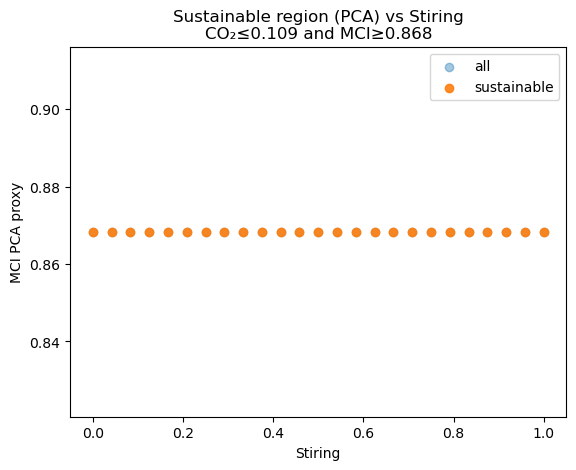

✅ Saved: data/results/scenario_sustainable_region_pca_Stiring_rf.png


In [11]:
def sustainable_mask(df, co2_col, mci_col, q_co2=0.25, q_mci=0.75):
    co2_thr = df[co2_col].quantile(q_co2)
    mci_thr = df[mci_col].quantile(q_mci)
    return (df[co2_col] <= co2_thr) & (df[mci_col] >= mci_thr), co2_thr, mci_thr

for var in scenario_vars:
    dfv = out[out["_var"] == var].sort_values("_val")
    mask, co2_thr, mci_thr = sustainable_mask(dfv, "co2_pca", "mci_pca")

    plt.figure()
    plt.title(f"Sustainable region (PCA) vs {var}\nCO₂≤{co2_thr:.3g} and MCI≥{mci_thr:.3g}")
    plt.xlabel(var)
    plt.ylabel("MCI PCA proxy")
    plt.scatter(dfv["_val"], dfv["mci_pca"], alpha=0.4, label="all")
    plt.scatter(dfv.loc[mask, "_val"], dfv.loc[mask, "mci_pca"], alpha=0.9, label="sustainable")
    plt.legend()
    p = results_dir / f"scenario_sustainable_region_pca_{var}_{best_name}.png"
    plt.savefig(p, dpi=200, bbox_inches="tight")
    plt.show()
    print("✅ Saved:", p.relative_to(repo_root))
